In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# make Numpy printouts easier to read
np.set_printoptions(precision=3,suppress=True)

In [2]:
# importing files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Get the data online
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders','Displacement', 'Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset = pd.read_csv(url, names = column_names, na_values = '?', comment = '\t', sep = ' ', skipinitialspace = True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# clean the data
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# drops the null values if any
dataset = dataset.dropna()

In [7]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe',3:'Japan'})

In [8]:
dataset = pd.get_dummies(dataset,columns=['Origin'], prefix='',prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [9]:
#dividing train and test folders
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [13]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [14]:
# normalization
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

In [16]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [17]:
first = np.array(train_features[:1])

In [18]:
with np.printoptions(precision=2, suppress=True):
    print('First example: ',first)
    print()
    print('Normalized: ',normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [19]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,],axis = None)
horsepower_normalizer.adapt(horsepower)

In [20]:
# Build The keras model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
horsepower_model.predict(horsepower[:10])

array([[-0.111],
       [-0.063],
       [ 0.206],
       [-0.156],
       [-0.141],
       [-0.055],
       [-0.167],
       [-0.141],
       [-0.037],
       [-0.063]], dtype=float32)

In [22]:
# compilation
horsepower_model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error'
)

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    #Suppress logging.
    verbose=0,
    # calculate validation results on 20% of the training data
    validation_split=0.2)

Wall time: 5.72 s


In [24]:
# visualising the model
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802980,4.190923,95
96,3.807570,4.193498,96
97,3.802930,4.187655,97
98,3.802579,4.194586,98
99,3.803736,4.201775,99


In [25]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.ylim([0,10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

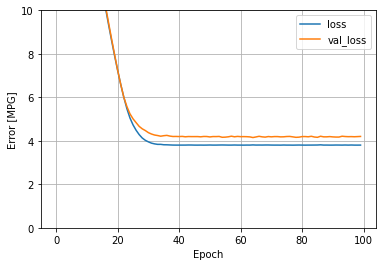

In [26]:
plot_loss(history)

In [27]:
test_results={}
test_results['horsepower_model']=horsepower_model.evaluate(test_features['Horsepower'],test_labels,verbose=0)

In [28]:
x=tf.linspace(0.0,250,251)
y=horsepower_model.predict(x)

In [29]:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'],train_labels,label='Data')
    plt.plot(x,y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

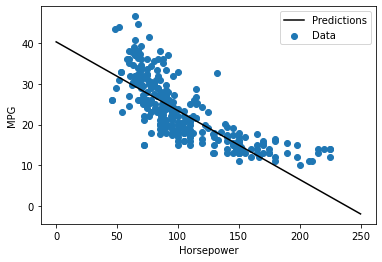

In [30]:
plot_horsepower(x,y)

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [32]:
linear_model.predict(train_features[:10])

array([[ 0.138],
       [-0.797],
       [ 0.22 ],
       [-1.304],
       [ 0.679],
       [-1.371],
       [ 0.447],
       [-1.194],
       [-0.579],
       [ 1.864]], dtype=float32)

In [33]:
linear_model.compile(
optimizer=tf.optimizers.Adam(learning_rate=0.1),
loss='mean_absolute_error')

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    #Suppress logging.
    verbose=0,
    # calculate validation results on 20% of the training data
    validation_split=0.2
    )

Wall time: 6.37 s


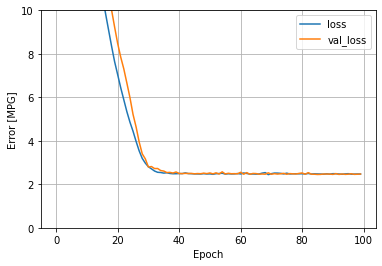

In [35]:
plot_loss(history)

In [36]:
test_results['liner_model'] = linear_model.evaluate(
    test_features,test_labels,verbose=0)

In [37]:
from keras import regularizers

In [38]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [39]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [40]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [41]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

Wall time: 3.69 s


In [42]:
x = tf.linspace(0.0, 250,251)
y = dnn_horsepower_model.predict(x)

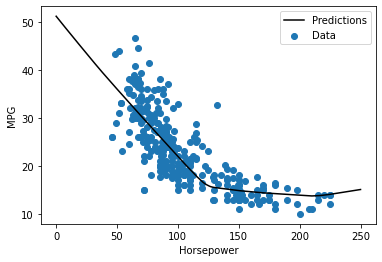

In [43]:
plot_horsepower(x,y)

In [44]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
test_features['Horsepower'],test_labels,
verbose = 0)

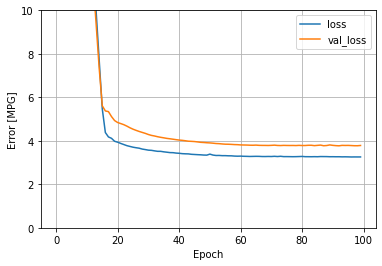

In [45]:
plot_loss(history)

In [46]:
# multiple inputs
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 4.73 s


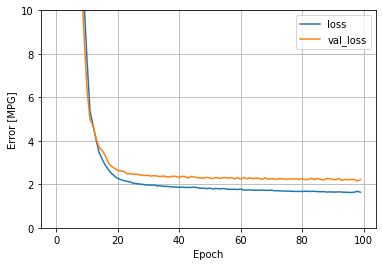

In [48]:
plot_loss(history)

In [49]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose = 0)

In [50]:
weights = dnn_model.get_weights()

In [51]:
# performance
pd.DataFrame(test_results, index = ['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.643197
liner_model,2.489673
dnn_horsepower_model,2.942359
dnn_model,1.654243


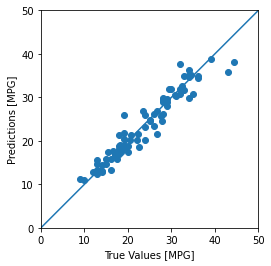

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

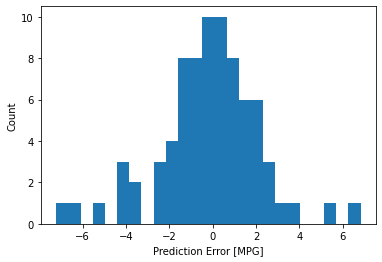

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [54]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [55]:
def build_and_compile_model_2(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu',input_dim = 64,kernel_regularizer = regularizers.l1(0.01)),
        layers.Dense(64,activation='relu',input_dim = 64,kernel_regularizer = regularizers.l1(0.01)),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [56]:
dnn_model_reg = build_and_compile_model_2(normalizer)
dnn_model_reg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [57]:
%%time
history = dnn_model_reg.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 6.03 s


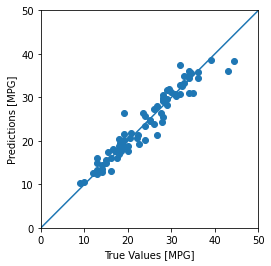

In [58]:
test_predictions = dnn_model_reg.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

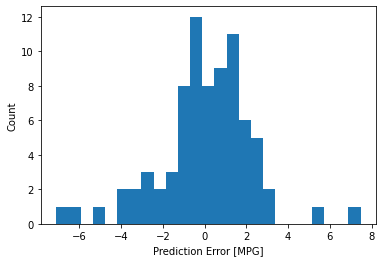

In [59]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [60]:
dnn_model_reg.save('dnn_model_regularization')

INFO:tensorflow:Assets written to: dnn_model_regularization\assets


In [61]:
test_results['dnn_model_regularization'] = dnn_model_reg.evaluate(test_features, test_labels, verbose = 0)

In [62]:
test_results

{'horsepower_model': 3.6431970596313477,
 'liner_model': 2.489672899246216,
 'dnn_horsepower_model': 2.942359209060669,
 'dnn_model': 1.6542428731918335,
 'dnn_model_regularization': 3.42553448677063}

In [63]:
pd.DataFrame(test_results, index = ['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.643197
liner_model,2.489673
dnn_horsepower_model,2.942359
dnn_model,1.654243
dnn_model_regularization,3.425534


In [64]:
from keras.layers.core import Dropout

In [65]:
def build_and_compile_model_3(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu',input_dim = 64),
        Dropout(0.25),
        layers.Dense(64,activation='relu',input_dim = 64),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [66]:
dnn_model_drop = build_and_compile_model_3(normalizer)
dnn_model_drop.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_11 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [67]:
%%time
history = dnn_model_drop.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 5.51 s


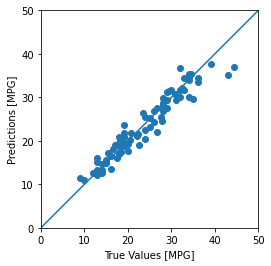

In [68]:
test_predictions = dnn_model_drop.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

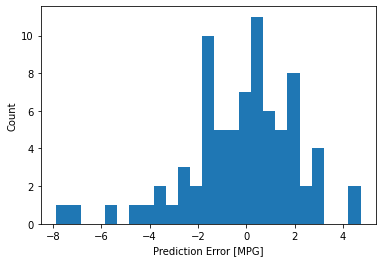

In [69]:
error = test_predictions - test_labels
plt.hist(error, bins =25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [70]:
dnn_model_drop.save('dnn_model_dropout')

INFO:tensorflow:Assets written to: dnn_model_dropout\assets


In [71]:
test_results['dnn_model_dropout'] = dnn_model_drop.evaluate(test_features, test_labels, verbose = 0)

In [72]:
test_results

{'horsepower_model': 3.6431970596313477,
 'liner_model': 2.489672899246216,
 'dnn_horsepower_model': 2.942359209060669,
 'dnn_model': 1.6542428731918335,
 'dnn_model_regularization': 3.42553448677063,
 'dnn_model_dropout': 1.723479986190796}